In [119]:
import numpy as np
import matplotlib.pyplot as plt
import struct
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

In [120]:
# mnist ref:http://yann.lecun.com/exdb/mnist/
# struct ref:https://www.cnblogs.com/gala/archive/2011/09/22/2184801.html
# numpy ref:numpy.org.cn/article/basics/numpy_matrices_vectors.html
def LoadImages(file):
    try:
        F = open(file, 'rb')
    except IOError:
        print("open error")
        F.close()

    f = F.read()

    offset=0
    fmt = '>iiii'
    magic, images, rows, columns = struct.unpack_from(fmt, f, offset)

    offset += struct.calcsize(fmt)
    fmt = '>' + str(rows * columns) + 'B'

    # images = 10 # for test

    # for CNN
    ImageSet = np.empty((images, 1, rows, columns))
    for i in range(images):
        ImageSet[i] = np.array(struct.unpack_from(fmt, f, offset)).reshape((1, rows, columns))
        offset += struct.calcsize(fmt)

    # for simple softmax
    # ImageSet = np.empty((images, rows * columns))
    # for i in range(images):
    #     ImageSet[i] = np.array(struct.unpack_from(fmt, f, offset)).reshape((rows*columns))
    #     offset += struct.calcsize(fmt)

    F.close()

    print(images)

    return ImageSet

In [121]:
def LoadLabels(file):
    try:
        F = open(file, 'rb')
    except IOError:
        print("open error")
        F.close()

    f = F.read()

    offset=0
    fmt = '>ii'

    magic, items = struct.unpack_from(fmt, f, offset)

    offset += struct.calcsize(fmt)
    fmt = '>B'

    # items = 10 # for test

    LabelSet = np.zeros((items, 10))
    for i in range(items):
        LabelSet[i][struct.unpack_from(fmt, f, offset)[0]] = 1
        offset += struct.calcsize(fmt)

    F.close()

    print(items)

    return LabelSet


In [122]:
# test
# im = LoadImages('train-images.idx3-ubyte')
# la = LoadLabels('train-labels.idx1-ubyte')
# plt.ion()
# for i in range(10):
#     plt.imshow(im[i], cmap='Greys')
#     print(la[i])
#     plt.pause(1)

In [123]:
# load training set
TrainImages_np = LoadImages('train-images.idx3-ubyte')
TrainLabels_np = LoadLabels('train-labels.idx1-ubyte')

TrainImages = torch.from_numpy(TrainImages_np)
TrainLabels = torch.from_numpy(TrainLabels_np)

60000
60000


In [124]:
# print(TrainImages)

In [125]:
# x = torch.randn(2,1,7,3)
# print(x)

In [126]:
# test
# print(TrainImages)
# print(TrainLabels)

In [127]:
# softmax with torch
# class SoftmaxNet(nn.Module):
#     def __init__(self, n_feature, n_hidden, n_output):
#         super(SoftmaxNet, self).__init__()
#         self.hidden = nn.Linear(n_feature, n_hidden)
#         self.predict = nn.Linear(n_hidden, n_output)

#     def forward(self, x):
        
#         x = F.relu(self.hidden(x))
#         x = self.predict(x)
#         return F.softmax(x, dim=1)

In [128]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.conv3 = nn.Conv2d(6, 16, 5)
        self.pool4 = nn.MaxPool2d(2, stride=2)
        self.full5 = nn.Linear(16*5*5, 120)
        self.full6 = nn.Linear(120, 84)
        self.out = nn.Linear(84,10)

    def forward(self, x):
        # x = F.relu(self.conv1(x))
        # x = F.relu(self.pool2(x))
        # x = F.relu(self.conv3(x))
        # x = F.relu(self.pool4(x))
        # x = x.view(x.size(0), -1)
        # x = F.relu(self.full5(x))
        # x = F.relu(self.full6(x))
        # x = F.relu(self.out(x))
        # x = F.softmax(x, dim=1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.pool2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.pool4(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.full5(x))
        x = F.relu(self.full6(x))
        x = self.out(x)
        x = F.softmax(x, dim=1)
        return x

In [129]:
net = CNN()
print(net)


CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (full5): Linear(in_features=400, out_features=120, bias=True)
  (full6): Linear(in_features=120, out_features=84, bias=True)
  (out): Linear(in_features=84, out_features=10, bias=True)
)


$$out(N_i, C_{out_j})=bias(C_{out_j})+\sum^{C_{in}-1}{k=0}weight(C{out_j},k)\bigotimes input(N_i,k)$$

In [130]:
losslist = []
timelist = []
# errorlist = []
# errortimelist = []

In [131]:
TrainImages = torch.tensor(TrainImages, dtype=torch.float32)
TrainLabels = torch.tensor(TrainLabels, dtype=torch.float32)

In [132]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.02)
loss_func = nn.MSELoss()

In [133]:
BATCH_SIZE = 64

torch_dataset = D.TensorDataset(TrainImages, TrainLabels)

loader = D.DataLoader(
    dataset=torch_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
)

for epoch in range(8):
    for step, (batch_x, batch_y) in enumerate(loader):
        
        prediction = net(batch_x)
        loss = loss_func(prediction, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # for test
        if step % 100 == 0:
            print(loss.data.numpy())

        losslist.append(loss.data.numpy())
        timelist.append(step + epoch * 938)

        # print('Epoch: ', epoch, '| Step: ', step, '| batch x: ',
        #       batch_x.numpy(), '| batch y: ', batch_y.numpy())

0.13591984
0.056429826
0.032945104
0.029444283
0.020181704
0.0151721835
0.01668989
0.009262487
0.012384703
0.011637414
0.017331194
0.013730411
0.015499999
0.013506353
0.005730804
0.005680104
0.00820451
0.0075619183
0.004281896
0.006993859
0.0025378056
0.003575304
0.0034775827
0.003269832
0.0037440404
0.008792534
0.006115596
0.008079905
0.004279732
0.0029835603
0.010121138
0.0039447895
0.0033900272
0.0044027893
0.0076221726
0.0022526667
0.01755515
0.0065546026
0.0035783486
0.005062726
0.004952898
0.00886155
0.0038962178
0.012083174
0.0044366783
0.004748405
0.007911602
0.0030066124
0.002491436
0.003374889
0.0025977795
0.0036331154
0.0019757096
0.00070586405
0.0056928466
0.0012635964
0.005063842
0.007185594
0.0072375005
0.001435527
0.0050758384
0.0019246277
0.0030251972
0.0024129837
0.0077284933
0.00024663607
0.0061480827
0.002224549
0.0026002708
0.0008158704
0.0031570524
0.00046579697
0.0041535357
0.0035565645
0.0035073485
0.004670278
0.00092288386
0.002297184
0.00016390884
0.0012109708


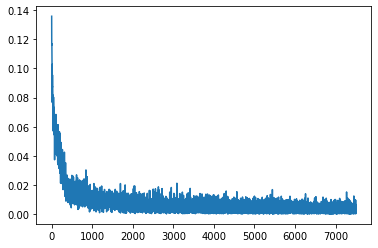

In [134]:
plt.plot(timelist, losslist)

In [135]:
def result(np_array):
    # print(np_array)
    max = np_array[0]
    num = 0
    for i in range(10):
        if np_array[i] > max:
            max = np_array[i]
            num = i
    return num

In [136]:
# plt.ion()
# for i in range(10):
    
    # print((TrainLabels.numpy())[i])
    # print((prediction.detach().numpy())[i])
    # plt.imshow(((TrainImages.numpy())[i]).reshape((28, 28)), cmap='Greys')
    # plt.pause(1)
TrainImages = torch.tensor(TrainImages, dtype=torch.float32)

prediction = net(TrainImages)

CurrLabels = (TrainLabels.numpy())
CurrPrediction = prediction.detach().numpy()

# eps = 0.1
# print(eps)

print(CurrLabels[:10])
print(CurrPrediction[:10])

CountError = 0
CountTotal = 0

print(CurrLabels.size, CurrPrediction.size)

for i in range(60000):
    # print(result(CurrLabels[i]))
    # print(result(CurrPrediction[i]))
    CountTotal += 1
    if result(CurrLabels[i]) != result(CurrPrediction[i]):
        CountError += 1

print(float(CountError)/float(CountTotal))
# print(np.max(CurrLabels, axis=1))
# print(np.max(CurrPrediction, axis=1))

# print((np.where(CurrLabels==np.max(CurrLabels, axis=1))))
# print((np.where(abs(CurrPrediction - np.max(CurrPrediction, axis=1))<eps)))

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
[[8.9721334e-07 1.2348978e-07 1.8533136e-05 2.5585180e-02 8.8150744e-11
  9.7438705e-01 1.1533874e-07 8.8750159e-07 5.1586571e-06 2.0682828e-06]
 [9.9999833e-01 2.8999705e-09 4.1650361e-07 6.7372913e-11 6.1801515e-11
  3.0956759e-09 1.2936705e-06 3.5435296e-08 9.5121647e-11 8.6244978e-10]
 [2.6037705e-10 5.8352578e-07 2.2487399e-07 2.7595748e-08 9.9992681e-01
  8.6118812e-10 1.2121309e-08 5.2729029e-05 2.6207534e-08 1.9604022e-05]
 [1.9086448e-04 9.9708301e-01 1.0574413e-05 1.7989148e-06 1.2376545e-03
  1.2219754e-06 2.6270087e-04 2.6567839e-04 8.8411826e-04 6.2436033e-05]
 [6.7228825e-08 6.8582165e-05 2.1314511e-06 5.8728663e-05 1.3573567e-03
  2.1407150e-05 1

In [137]:
TestImages_np = LoadImages('t10k-images.idx3-ubyte')
TestLabels_np = LoadLabels('t10k-labels.idx1-ubyte')

TestImages = torch.from_numpy(TestImages_np)
TestImages = torch.tensor(TestImages, dtype=torch.float32)

prediction = net(TestImages)

CurrLabels = TestLabels_np
CurrPrediction = (prediction.detach().numpy())

# eps = 0.1
# print(eps)

print(CurrLabels[:10])
print(CurrPrediction[:10])

CountError = 0
CountTotal = 0

for i in range(10000):
    # print(result(CurrLabels[i]))
    # print(result(CurrPrediction[i]))
    CountTotal += 1
    if result(CurrLabels[i]) != result(CurrPrediction[i]):
        CountError += 1

print(float(CountError)/float(CountTotal))

10000
10000
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[1.70907430e-08 2.00839401e-10 8.38473795e-07 1.59894864e-06
  1.58478219e-09 2.32416113e-08 1.47718209e-13 9.99996662e-01
  1.71506553e-09 8.67338372e-07]
 [2.08461381e-04 6.65427287e-05 9.99722421e-01 1.10938231e-06
  2.17962315e-09 1.65574345e-08 1.08560539e-06 3.20724385e-11
  3.62788455e-07 3.13149924e-13]
 [7.59224698e-04 9.94468808e-01 1.32991132e-04 8.17060391e-06
  2.58675707e-03 1.26599980e-05 7.59317772e-04 9.71566187e-05
  1.12065091e-03 5.41485169e-05]
 [9.99737918e-01 9.32631892e-08 4.06968975e-05 2.79073639e-11
  5.86938009e-09 3.65292898e-08 2.21178823e-04 6.89354067e-08
  2.35323483e-10 1.51599178e-08]
 [1.95111340e-07 4.41804877e-

In [138]:
# save model
torch.save(net.state_dict(), './model-version-2-args.model')

In [139]:
# net = CNN()
# net.load_state_dict(torch.load('./model-version-1-args.model'))